# Global Diferential Privacy Assessement: Univariate case

In this notebook, we will explore the univariate case of the Global Differential Privacy using a different application. After running this notebook, you will be able to:
- Understand the concept and applying Gaussian based Global Differential Privacy for univariate case.

We also run a monte carl simulation to validate the GDP implementation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import wget
from rich import print

## Global Differential Privacy

Global Differential Privacy (DP) is a mathematical framework that provides strong, quantifiable privacy guarantees when analyzing and sharing data. Its core idea is to ensure that the inclusion or exclusion of a single individual’s data does not significantly affect the output of an analysis, thereby limiting what can be inferred about any one person. This limits the ability of an attacker to infer whether someone participated in the dataset, even if they possess additional background information. To achieve this, DP algorithms inject calibrated random noise into outputs.

## User Output

A data user has an analysis pipeline that s run on the data. The output of such pipeline is then made differentially private.

Here, the pipeline simply consists in computing the mean.


In [2]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

## GDP algorithm

The procedure take the user pipeline and data and applies a leave one out (loo) resampling to the data to obtain the influence function, i.e. the output of the user pipeline for each loo resample are compared to the user output. The maximum of that gives the lower bound of the noise to be applied (i.e. it provides the information on the observation which has the largest influence).  



## Noise Extraction - Laplace Vs. Gaussian Distribution

Here, we compare noise sampling strategies from Normal and Laplace distributions for use in our DP setting. The goal is to assess how different distributions behave when bounded by a known sensitivity which is estimated via LOO sampling.

loo_output: [180.04927947170668, 176.93212213639086, 178.5781384080983, 176.35140275891834, 
176.7850214428807, 179.39939932582587, 179.5738327619934, 177.9013971346368, 
178.59842866337218, 178.62665727124838], 
pipeline_output: 178.27956793750718

sensitivity: 1.9281651785888414

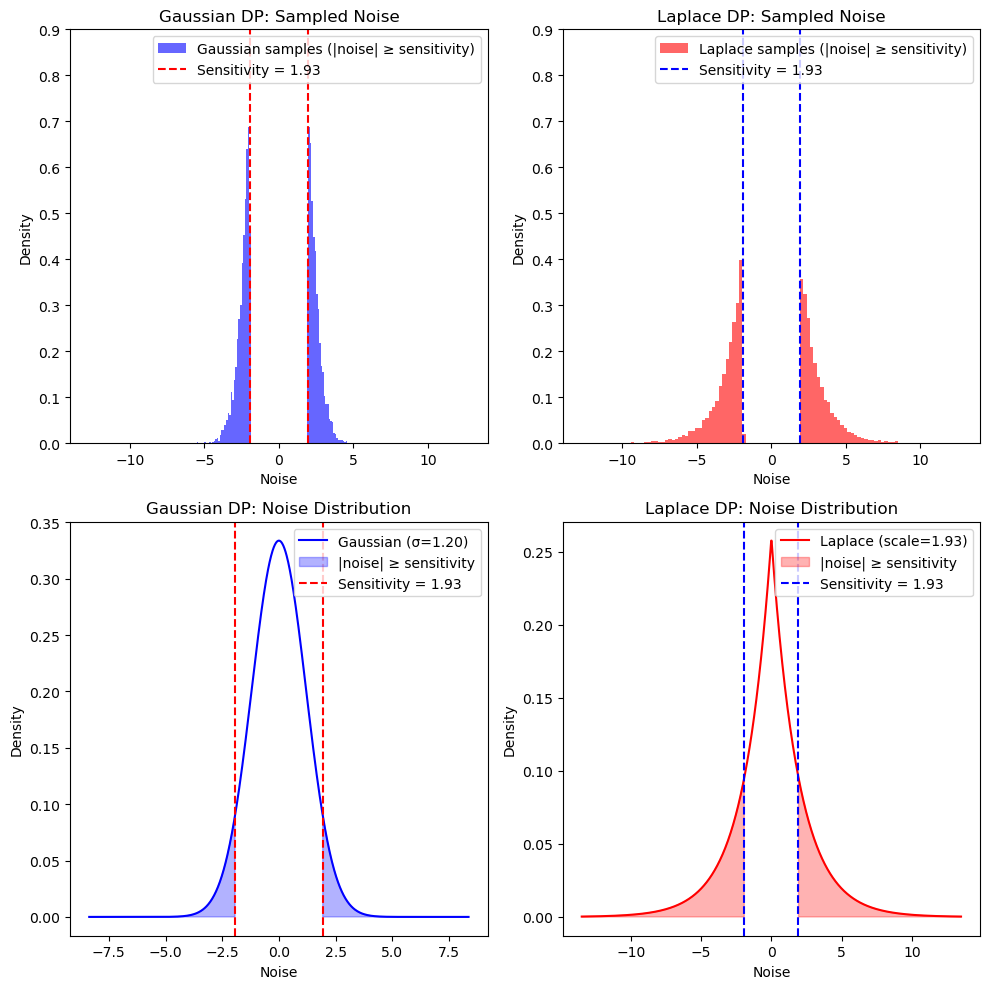

In [3]:
from scipy.stats import norm, laplace
clean_data = np.random.normal(loc=170, scale=10, size=10)
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
pipeline_output = user_output(loo_data)
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"loo_output: {list(loo_output)}, \npipeline_output: {pipeline_output}")
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\nsensitivity: {sensitivity}")
n = len(clean_data)

loo_scale = np.std(loo_output)  
noise_gaussian = []
for _ in range(10000):
    while True:
        noise = np.random.normal(loc=0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian.append(noise)
            break

scale_laplace = sensitivity 
noise_laplace = []
for _ in range(10000):
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_laplace.append(noise)
            break


# VIZ

plt.figure(figsize=(10, 10))  

plt.subplot(2, 2, 1) 
plt.hist(noise_gaussian, bins=100, density=True, alpha=0.6, color='blue', 
         label='Gaussian samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 2)  
plt.hist(noise_laplace, bins=100, density=True, alpha=0.6, color='red', 
         label='Laplace samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Laplace DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 3)  
x_g = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_g, norm.pdf(x_g, 0, loo_scale), 'b-', label=f'Gaussian (σ={loo_scale:.2f})')
plt.fill_between(x_g, norm.pdf(x_g, 0, loo_scale), 
                 where=(np.abs(x_g) >= sensitivity), color='blue', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)  
x_l = np.linspace(-7*scale_laplace, 7*scale_laplace, 1000)
plt.plot(x_l, laplace.pdf(x_l, 0, scale_laplace), 'r-', label=f'Laplace (scale={scale_laplace:.2f})')
plt.fill_between(x_l, laplace.pdf(x_l, 0, scale_laplace), 
                 where=(np.abs(x_l) >= sensitivity), color='red', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Laplace DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

## Different setup for noise 

**Why Use 2 * std for Normal Distribution?**

In a Gaussian distribution, roughly 95% of the data falls within +/- 2 standard deviations. When we're sampling noise, that must exceed a minimum threshold (the sensitivity), a standard deviation that is too small will result in excessive rejection sampling, simply saying, most noise samples are too small and get discarded.

By using 2 * std:

- We increase the spread of the distribution.
- This reduces the rejection rate, allowing more efficient sampling of noise that meets the sensitivity requirement.
- It reflects a practical compromise between privacy guarantees and computational efficiency for tail sampling.

loo_output: [168.083797709547, 166.6723726685689, 166.50359539656057, 166.65762184133916, 
168.61108959033572, 166.05608014058387, 168.66735782116024, 167.1263906379506, 
167.98085561077406, 168.84137844959383], 
pipeline_output: 167.5200539866414

sensitivity: 1.4639738460575131

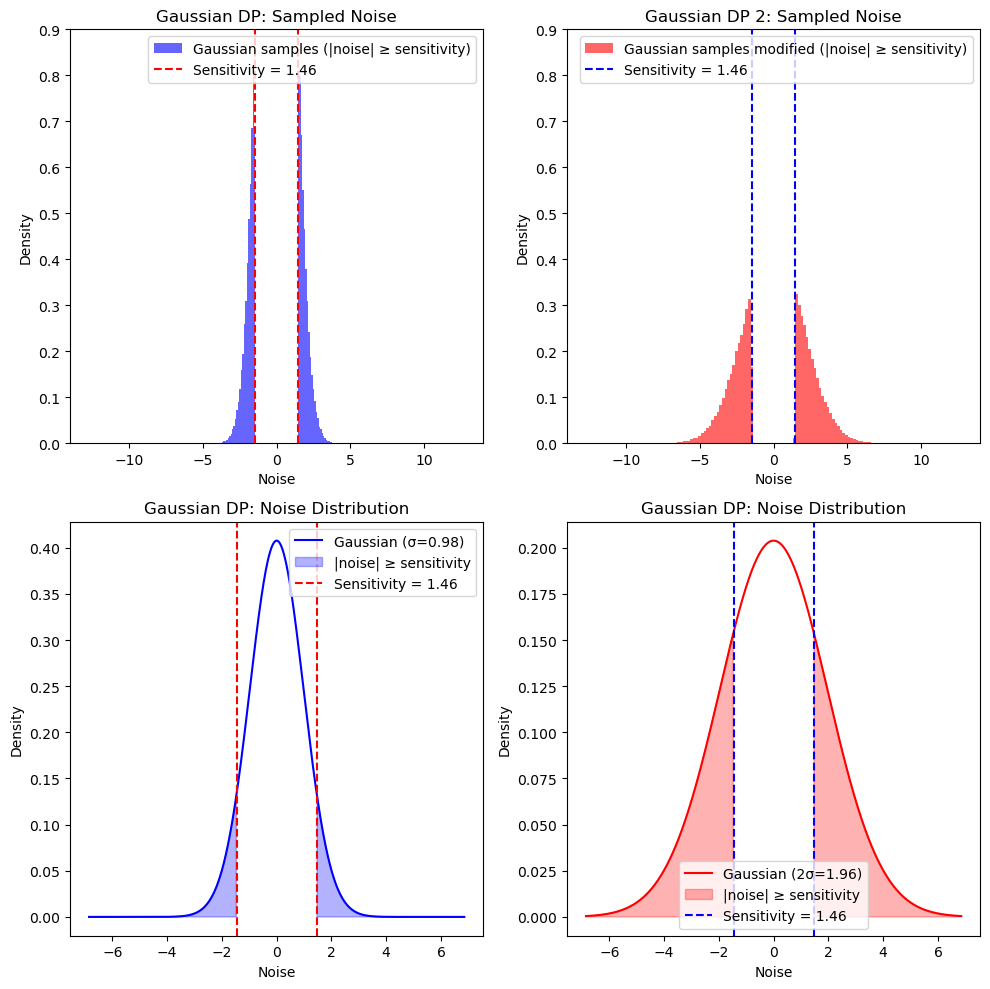

In [4]:
clean_data = np.random.normal(loc=170, scale=10, size=10)
loo_data = np.array([np.delete(clean_data, i) for i in range(len(clean_data))])
pipeline_output = user_output(loo_data)
loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
print(f"loo_output: {list(loo_output)}, \npipeline_output: {pipeline_output}")
sensitivity = np.max(np.abs(loo_output - pipeline_output))
print(f"\nsensitivity: {sensitivity}")

n = len(clean_data)

loo_scale = np.std(loo_output)  
#scale = max(loo_scale, sensitivity / np.sqrt(2 * np.log(1.1)))  
noise_gaussian = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian.append(noise)
            break

noise_gaussian_2 = []
for _ in range(100000):
    while True:
        noise = np.random.normal(loc=0, scale=2 * loo_scale)
        if np.abs(noise) >= sensitivity:
            noise_gaussian_2.append(noise)
            break



# VIZ
plt.figure(figsize=(10, 10))  

plt.subplot(2, 2, 1) 
plt.hist(noise_gaussian, bins=100, density=True, alpha=0.6, color='blue', 
         label='Gaussian samples (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 2)  
plt.hist(noise_gaussian_2, bins=100, density=True, alpha=0.6, color='red', 
         label='Gaussian samples modified (|noise| ≥ sensitivity)')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Gaussian DP 2: Sampled Noise')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()
plt.xlim(-14, 14)
plt.ylim(0, 0.9)

plt.subplot(2, 2, 3)  
x_g = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_g, norm.pdf(x_g, 0, loo_scale), 'b-', label=f'Gaussian (σ={loo_scale:.2f})')
plt.fill_between(x_g, norm.pdf(x_g, 0, loo_scale), 
                 where=(np.abs(x_g) >= sensitivity), color='blue', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='red', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='red', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.subplot(2, 2, 4)  
x_l = np.linspace(-7*loo_scale, 7*loo_scale, 1000)
plt.plot(x_l, norm.pdf(x_l, 0, 2 * loo_scale), 'r-', label=f'Gaussian (2σ={(2*loo_scale):.2f})')
plt.fill_between(x_g, norm.pdf(x_l, 0, 2*loo_scale), 
                 where=(np.abs(x_l) >= sensitivity), color='red', alpha=0.3,
                 label='|noise| ≥ sensitivity')
plt.axvline(x=sensitivity, color='blue', linestyle='--', label=f'Sensitivity = {sensitivity:.2f}')
plt.axvline(x=-sensitivity, color='blue', linestyle='--')
plt.title('Gaussian DP: Noise Distribution')
plt.xlabel('Noise')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Main Pipeline

In [5]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output

def dp(clean_data,pipeline_output):


    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise = np.random.normal(loc=0.0, scale=2 * loo_scale)
        if abs(noise) >= sensitivity:
            break

    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity

def iqr_bounds(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return iqr, lower_bound, upper_bound

def outlier_(value, lower, upper):
    return value < lower or value > upper
    

In [6]:
def sim(n_replicates, subsample_sizes, OL=True):    
    id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
    counts = {size: 0 for size in subsample_sizes}
    reconstructed = {size: [] for size in subsample_sizes}
    true_means_ = {size: [] for size in subsample_sizes}
    sensitivities_ = {size: [] for size in subsample_sizes}
    error_ = {size: [] for size in subsample_sizes}
    
    for n in range(n_replicates):
        data = np.random.normal(loc=170, scale=10, size=200)
        for size in subsample_sizes:
            subsample = data[:size].copy()
            iqr_, lower_b, upper_b = iqr_bounds(subsample)
            
            if OL:
                outlier_val = lower_b - 100
                subsample[0] = outlier_val
            else: pass

            true_mean = np.mean(subsample)
            true_means_[size].append(true_mean)
            loo_data = np.array([np.delete(subsample, i) for i in range(len(subsample))])
            ######## PIPELINE ########
            noisy_outputs = []
            sens_outputs = []
            for loo_subset in loo_data:
                output = user_output(loo_subset)
                noisy_output, sensitivity_ = dp(loo_subset, output)
                noisy_outputs.append(noisy_output)
                sens_outputs.append(sensitivity_)
                
            ######## RECONSTRUCTION ########
            coeff_mat = np.ones((size, size)) - np.eye(size)
            recons = np.linalg.solve(coeff_mat, (size - 1) * np.array(noisy_outputs))
            iqr_, lower_b, upper_b = iqr_bounds(recons)
            recons_error = np.mean(abs(recons - subsample))
            error_[size].append(recons_error)
            sensitivities_[size].append(sens_outputs)
            reconstructed[size].append(recons)
            
            if outlier_(recons[0], lower_b, upper_b):
                counts[size] += 1
                
            for idx in range(size):
                if outlier_(recons[idx], lower_b, upper_b):
                    id_dr[size][idx] += 1
    return id_dr, counts, reconstructed, sensitivities_, error_


import time
start = time.time()
n_replicates = 2000
subsample_sizes = [20, 40, 60, 80, 100]

id_dr_OL, counts_OL, reconstructed_OL, sensitivities_OL, error_OL = sim(n_replicates, subsample_sizes, OL=True)
id_dr, counts, reconstructed, sensitivities_, error_ = sim(n_replicates, subsample_sizes, OL=False)
print(f"None-optimized end time: {time.time() - start}")

from src.sim import *
start = time.time()
id_dr_OL, counts_OL, reconstructed_OL, sensitivities_OL, error_OL = sim_(n_replicates, np.array(subsample_sizes), OL=True)
id_dr, counts, reconstructed, sensitivities_, error_ = sim_(n_replicates, np.array(subsample_sizes), OL=False)
print(f"Optimized end time: {time.time() - start}")

None-optimized end time: 3178.466866016388

OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 64 or lower


Optimized end time: 12.665410041809082

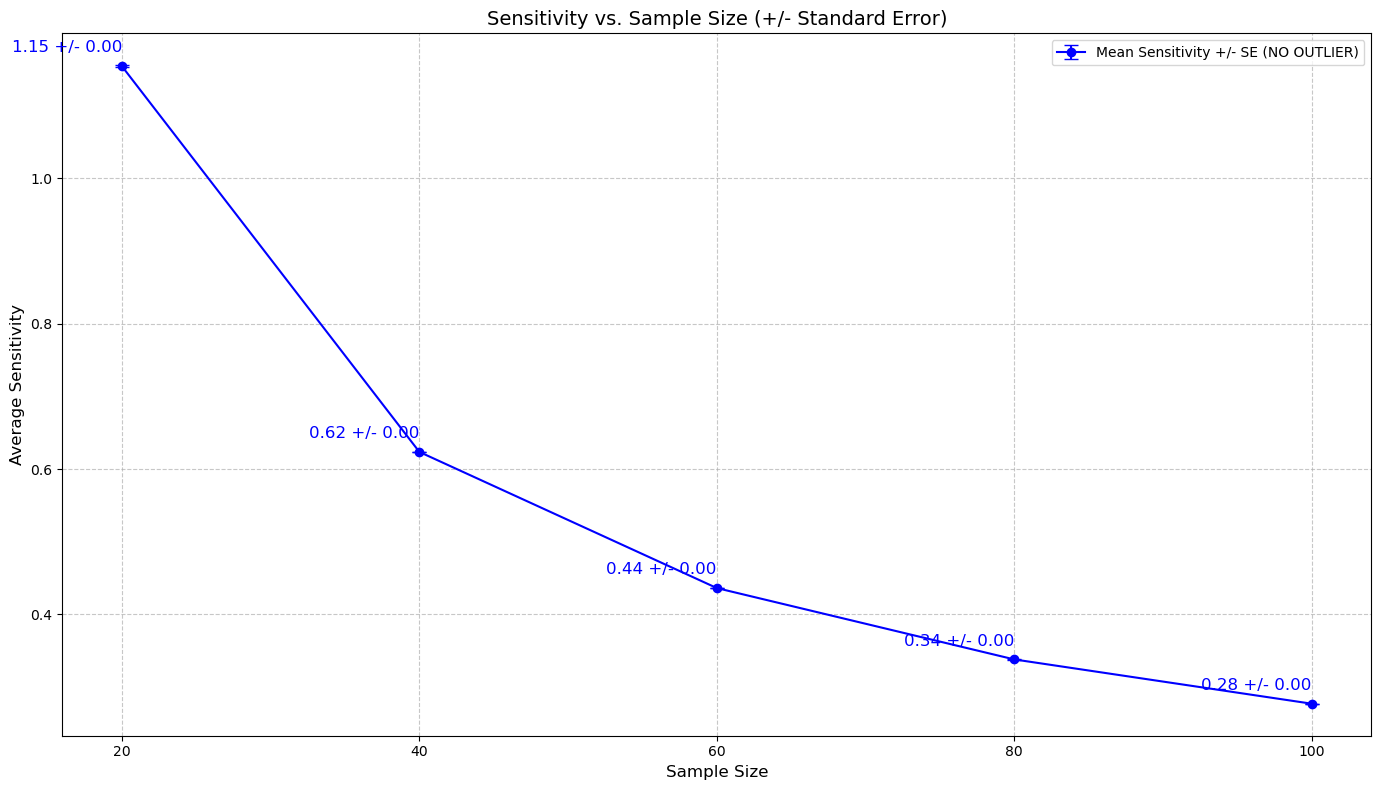

In [15]:
mean_sensitivities = []
std_errors = []

for si, size in enumerate(subsample_sizes):
    all_sensitivities = sensitivities_[si, :, :size].flatten()
    mean_sens = np.mean(all_sensitivities)
    std_err = np.std(all_sensitivities) / np.sqrt(len(all_sensitivities))
    mean_sensitivities.append(mean_sens)
    std_errors.append(std_err)

plt.figure(figsize=(14, 8))

plt.errorbar(
    subsample_sizes, mean_sensitivities, yerr=std_errors,
    fmt='o-', capsize=5, color='blue',
    label='Mean Sensitivity +/- SE (NO OUTLIER)'
)

for size, sens, err in zip(subsample_sizes, mean_sensitivities, std_errors):
    plt.annotate(
        f"{sens:.2f} +/- {err:.2f}", 
        (size, sens),
        textcoords="offset points", 
        xytext=(0, 10),
        ha='right', 
        fontsize=12,
        color='blue'
    )

plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('Average Sensitivity', fontsize=12)
plt.title('Sensitivity vs. Sample Size (+/- Standard Error)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(subsample_sizes)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()


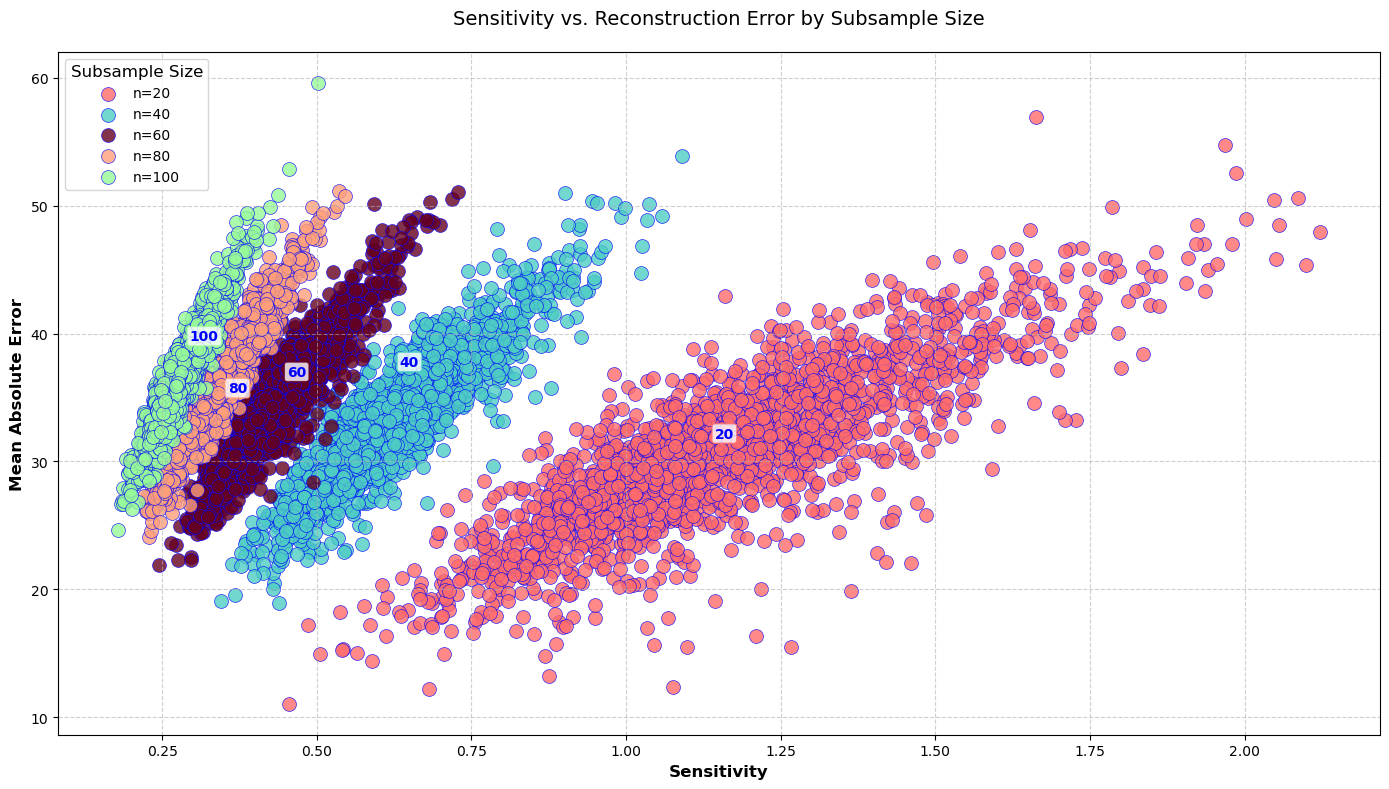

In [17]:
color_map = {
    20: '#FF6B6B',
    40: '#4ECDC4',
    60: '#650021',
    80: '#FFA07A',
    100: '#98FB98',
 }

plt.figure(figsize=(14, 8))

for si, size in enumerate(subsample_sizes):
    mean_sensitivity = np.mean(sensitivities_[si, :, :size], axis=1)
    plt.scatter(mean_sensitivity,
                error_[si, :],
                color=color_map[size],
                s=100,
                alpha=0.8,
                edgecolors='b',
                linewidth=0.5,
                label=f'n={size}')

    median_idx = np.argsort(mean_sensitivity)[len(mean_sensitivity) // 2]
    plt.annotate(f'{size}',
                 xy=(mean_sensitivity[median_idx], error_[si, median_idx]),
                 xytext=(10, 10),
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color="b",
                 bbox=dict(boxstyle='round,pad=0.2',
                           fc='white',
                           ec=color_map[size],
                           alpha=0.8))

plt.xlabel('Sensitivity', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.title('Sensitivity vs. Reconstruction Error by Subsample Size',
          fontsize=14, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Subsample Size', title_fontsize=12)

plt.tight_layout()
plt.show()


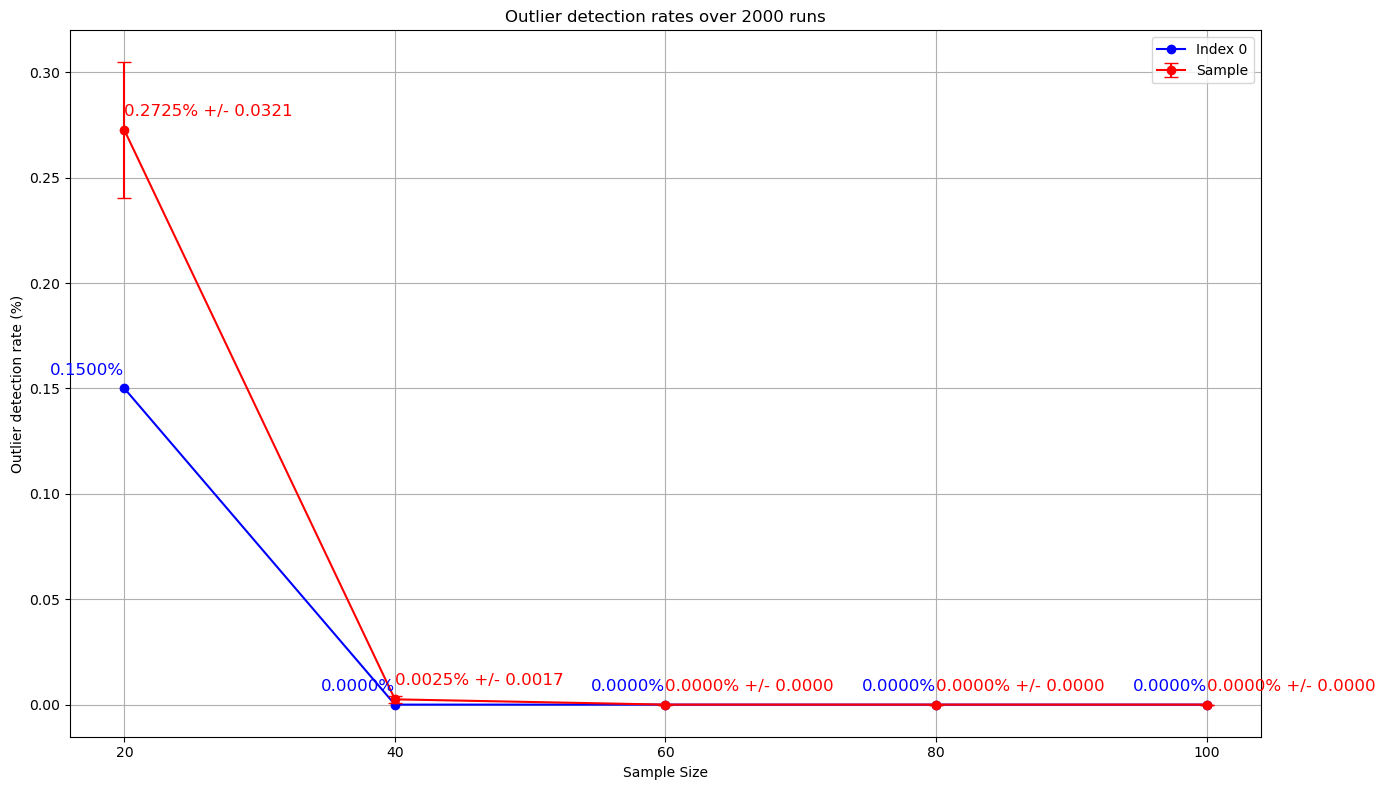

In [16]:
detection_rates = (counts_OL / n_replicates) * 100
prc = (id_dr_OL / n_replicates) * 100

means = []
errors = []
pop_size = []

for si, size in enumerate(subsample_sizes):
    percentages = (id_dr[si, :size] / n_replicates) * 100
    mean_val = np.mean(percentages)
    se_val = np.std(percentages, ddof=1) / np.sqrt(len(percentages))
    means.append(mean_val)
    errors.append(se_val)
    pop_size.append(size)

plt.figure(figsize=(14, 8))

plt.plot(subsample_sizes, detection_rates, marker='o', linestyle='-', color='blue', label='Index 0')
for size, rate in zip(subsample_sizes, detection_rates):
    plt.annotate(f"{rate:.4f}%", (size, rate),
                 textcoords="offset points", xytext=(0, 10),
                 ha='right', fontsize=12, color='blue')

plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, color='red', label='Sample')
for x, y, err in zip(pop_size, means, errors):
    plt.annotate(f"{y:.4f}% +/- {err:.4f}",
                 xy=(x, y), xytext=(0, 10),
                 textcoords='offset points', ha='left',
                 fontsize=12, color='red')

plt.xlabel('Sample Size')
plt.ylabel('Outlier detection rate (%)')
plt.title(f'Outlier detection rates over {n_replicates} runs')
plt.grid(True)
plt.xticks(subsample_sizes)
plt.legend(loc=1)
plt.tight_layout()
plt.show()


The outlier detection here refers to how often the injected noise produces an output that is statistically flagged as an outlier.

What this plot shows, is that across all subsample sizes, the outlier detection rate remains consistently at 0%. This means the added noise never creates anomalous or suspicious values, regardless of how large or small the sample is. The mechanism produces outputs that remain statistically plausible and naturally blend in with expected values.

However since the method is foundamentally based on randomness, and earlier we mentioned that smaller datasets are more sensetive, we can expect information breach in small datasets. 

### Comparison to local privacy

Local privacy is something that one is more accustomed to. We simply have to add noise on each subject. Of course in project in which the data are completely private this is not possible, which is why gobal privacy can be used. It is however beneficial to compare the approach and results here.

We start by creating the local_dp object which noise data rahter than user_output

In [15]:
def local_dp(clean_data):

    sensitivity = np.abs(clean_data-user_output(clean_data))
    noise_values = np.zeros_like(clean_data)
    noisy_data = np.zeros_like(clean_data)
    for i in range(len(clean_data)):
        while True:
            noise = np.random.normal(loc=0.0, scale= 2 * sensitivity[i], size=1)
            if abs(noise[0]) >= sensitivity[i]:
                noise_values[i] = noise[0]
                break
        
        noisy_data[i] = clean_data[i] + noise_values[i] if noise_values[i] >= np.mean(clean_data) else clean_data[i] - noise_values[i]
    
    return noisy_data, sensitivity


In [16]:
def sim_local(n_replicates, subsample_sizes, OL=True):    
    id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
    counts = {size: 0 for size in subsample_sizes}
    reconstructed = {size: [] for size in subsample_sizes}
    true_means_ = {size: [] for size in subsample_sizes}
    sensitivities_ = {size: [] for size in subsample_sizes}
    error_ = {size: [] for size in subsample_sizes}
    
    for n in range(n_replicates):
        data = np.random.normal(loc=170, scale=10, size=100)
        for size in subsample_sizes:
            subsample = data[:size].copy()
            iqr_, lower_b, upper_b = iqr_bounds(subsample)
            
            if OL:
                outlier_val = lower_b - 100
                subsample[0] = outlier_val
            else: pass

            true_mean = np.mean(subsample)
            true_means_[size].append(true_mean)
            loo_data = np.array([np.delete(subsample, i) for i in range(len(subsample))])
            ######## PIPELINE ########
            private_data = []
            sens_outputs = []
            pr, se = local_dp(subsample)
            private_data.append(pr)
            sens_outputs.append(se)
            ######## RECONSTRUCTION ########
            coeff_mat = np.ones((size, size)) - np.eye(size)
            recons = np.linalg.solve(coeff_mat, (size - 1) * np.array(pr))
            iqr_, lower_b, upper_b = iqr_bounds(recons)

            recons_error = np.mean(abs(recons - subsample))
            error_[size].append(recons_error)
            sensitivities_[size].append(sens_outputs)
            reconstructed[size].append(recons)
            
            if outlier_(recons[0], lower_b, upper_b):
                counts[size] += 1
                
            for idx in range(size):
                if outlier_(recons[idx], lower_b, upper_b):
                    id_dr[size][idx] += 1
    return id_dr, counts, reconstructed, sensitivities_, error_


id_dr_OL, counts_OL, reconstructed_OL, sensitivities_OL, error_OL = sim_local(n_replicates, subsample_sizes, OL=True)
id_dr, counts, reconstructed, sensitivities_, error_ = sim_local(n_replicates, subsample_sizes, OL=False)

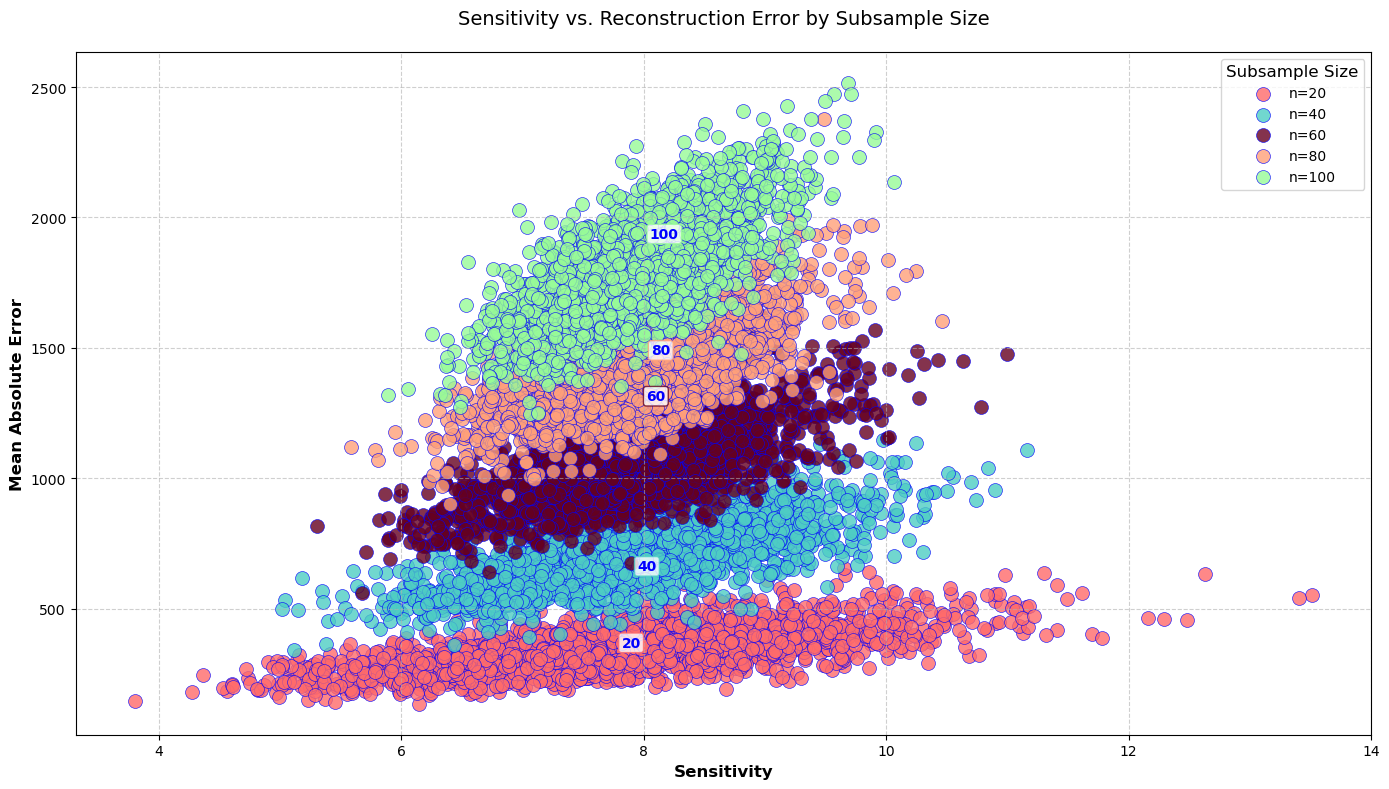

In [17]:
# https://matplotlib.org/stable/users/explain/colors/colors.html
color_map = {
    20: '#FF6B6B',  
    40: '#4ECDC4', 
    60: '#650021', 
    80: '#FFA07A',  
    100: '#98FB98',
 
}

plt.figure(figsize=(14, 8))

for size in subsample_sizes:
    mean_sensitivity = np.mean(np.array(sensitivities_[size]).reshape(n_replicates, size), axis=1)
    plt.scatter(mean_sensitivity, 
                np.array(error_[size]),
                color=color_map[size],
                s=100,  
                alpha=0.8,
                edgecolors='b',  
                linewidth=0.5,
                label=f'n={size}')

    median_idx = np.argsort(mean_sensitivity)[len(mean_sensitivity)//2]
    plt.annotate(f'{size}',
                 xy=(mean_sensitivity[median_idx], np.array(error_[size])[median_idx]),
                 xytext=(10, 10),  
                 textcoords='offset points',
                 fontsize=10,
                 fontweight='bold',
                 color="b", 
                 bbox=dict(boxstyle='round,pad=0.2', 
                          fc='white', 
                          ec=color_map[size],  
                          alpha=0.8))

plt.xlabel('Sensitivity', fontsize=12, fontweight='bold')
plt.ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
plt.title('Sensitivity vs. Reconstruction Error by Subsample Size', 
          fontsize=14, pad=20)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Subsample Size', title_fontsize=12)

plt.tight_layout()
plt.show()

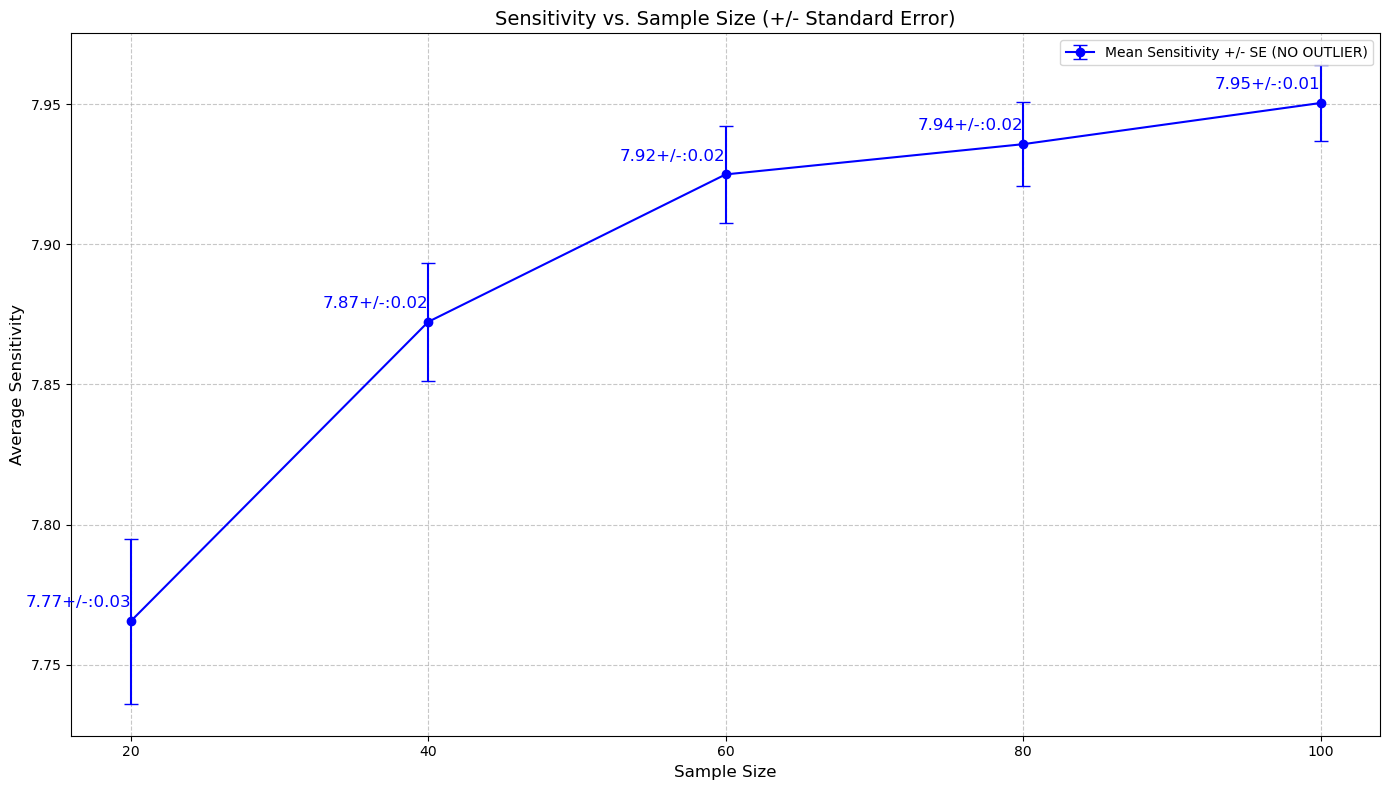

In [18]:
mean_sensitivities = list()
std_errors = list()

for size in subsample_sizes:
    all_sensitivities = np.array(sensitivities_[size]).flatten()
    mean_sens = np.mean(all_sensitivities)
    std_err = np.std(all_sensitivities) / np.sqrt(len(all_sensitivities))
    mean_sensitivities.append(mean_sens)
    std_errors.append(std_err)
    
plt.figure(figsize=(14, 8))

plt.errorbar(
    subsample_sizes, mean_sensitivities, yerr=std_errors,
    fmt='o-', capsize=5, color='blue',
    label='Mean Sensitivity +/- SE (NO OUTLIER)'
)


for size, sens, err in zip(subsample_sizes, mean_sensitivities, std_errors):
    plt.annotate(
        f"{sens:.2f}+/-:{err:.2f}", 
        (size, sens),
        textcoords="offset points", 
        xytext=(0, 10),
        ha='right', 
        fontsize=12,
        color='blue'
    )


plt.xlabel('Sample Size', fontsize=12)
plt.ylabel('Average Sensitivity', fontsize=12)
plt.title('Sensitivity vs. Sample Size (+/- Standard Error)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(subsample_sizes)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

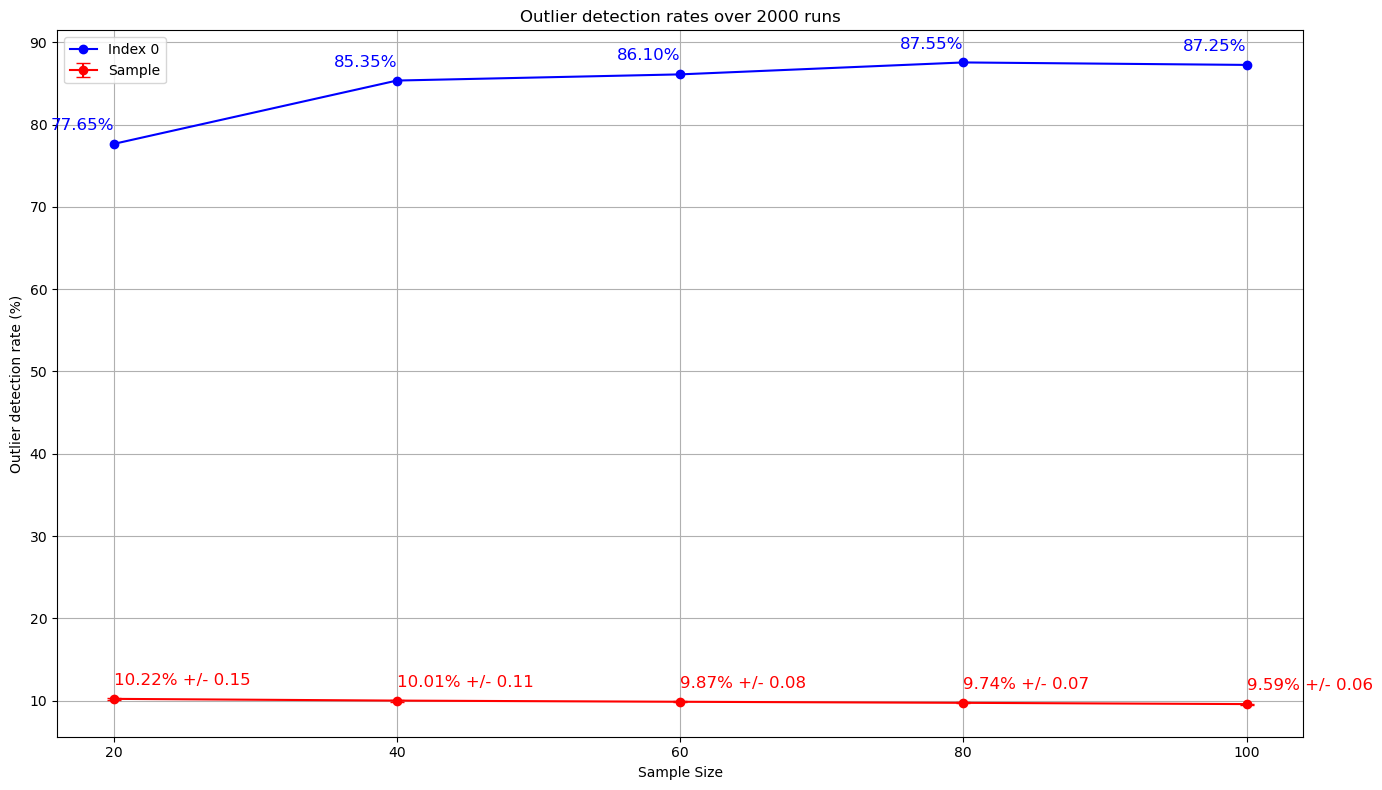

In [19]:
detection_rates = [(counts_OL[size] / n_replicates) * 100 for size in subsample_sizes]

prc = {size: (id_dr[size] / n_replicates) * 100 for size in subsample_sizes}
means, errors, pop_size = list(), list(), list()
for n, flags in id_dr.items():
    percentages = (flags / n_replicates) * 100
    mean = np.mean(percentages)
    se = np.std(percentages, ddof=1) / np.sqrt(len(flags))
    means.append(mean)
    errors.append(se)
    pop_size.append(n)

plt.figure(figsize=(14, 8))
plt.plot(subsample_sizes, detection_rates, marker='o', linestyle='-', color='blue', label='Index 0')
for size, rate in zip(subsample_sizes, detection_rates):
    plt.annotate(f"{rate:.2f}%", (size, rate), textcoords="offset points", xytext=(0, 10), ha='right', fontsize=12, color='blue')

plt.errorbar(pop_size, means, yerr=errors, fmt='-o', capsize=5, color='red', label='Sample')
for (x, y, err) in zip(pop_size, means, errors):
    plt.annotate(f"{y:.2f}% +/- {err:.2f}", xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='left', fontsize=12, color='red')

plt.xlabel('Sample Size')
plt.ylabel('Outlier detection rate (%)')
plt.title(f'Outlier detection rates over {n_replicates} runs')
plt.grid(True)
plt.xticks(subsample_sizes)
plt.legend(loc=2)
plt.tight_layout()
plt.show()


In [19]:
import time
n_replicates = 5000
subsample_sizes = [20, 40, 60, 80, 100]

from src.sim import *
start = time.time()
id_dr_OL, counts_OL, reconstructed_OL, sensitivities_OL, error_OL = sim_(n_replicates, subsample_sizes, OL=True)
id_dr, counts, reconstructed, sensitivities_, error_ = sim_(n_replicates, subsample_sizes, OL=False)
print(f"Optimized end time: {time.time() - start}")

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function max at 0x7fda8c246de0>) found for signature:
 
 >>> max(reflected list(int64)<iv=None>)
 
There are 2 candidate implementations:
[1m   - Of which 2 did not match due to:
   Overload of function 'max': File: numba/np/arraymath.py: Line 541.
     With argument(s): '(reflected list(int64)<iv=None>)':[0m
[1m    No match.[0m
[0m
[0m[1mDuring: resolving callee type: Function(<function max at 0x7fda8c246de0>)[0m
[0m[1mDuring: typing of call at /indirect/staff/vincentajoubi/Don't look/DL/CalibrateNoise/src/sim.py (51)
[0m
[1m
File "src/sim.py", line 51:[0m
[1mdef sim_(n_replicates, subsample_sizes, OL=True):
    <source elided>
    num_sizes = len(subsample_sizes)
[1m    max_size = np.max(subsample_sizes)
[0m    [1m^[0m[0m
